<a href="https://colab.research.google.com/github/ILoveCoder999/FederatedLearning/blob/master/centralizedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import module
import sys
sys.path.append('/content/drive/MyDrive')
from preprocessing import FederatedDataBuilder

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# ============================================================
# 1. Model Definition (with Dropout)
# ============================================================
class DINOCIFAR100(nn.Module):
    def __init__(self, num_classes=100, dropout_rate=0.1):
        super(DINOCIFAR100, self).__init__()
        print("Downloading/Loading DINO ViT-S/16...")
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        self.embed_dim = 384

        #  Add Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)  # ← Apply dropout before classification head
        return self.head(features)


# ============================================================
# 2. Training & Evaluation Functions
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: Neural network model
        loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device (cuda/cpu)

    Returns:
        avg_loss: Average loss for this epoch
        accuracy: Training accuracy (%)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """
    Evaluate the model on validation/test set.

    Args:
        model: Neural network model
        loader: Validation/test data loader
        criterion: Loss function
        device: Device (cuda/cpu)

    Returns:
        avg_loss: Average loss
        accuracy: Accuracy (%)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


# ============================================================
# 3. Warmup + Cosine Decay Learning Rate Scheduler
# ============================================================
def get_lr_schedule(optimizer, warmup_epochs=5, total_epochs=50):
    """
    Create a learning rate scheduler with Warmup + Cosine Decay.

    - First warmup_epochs: Linear warmup from 0 to initial LR
    - Remaining epochs: Cosine annealing decay

    Args:
        optimizer: Optimizer
        warmup_epochs: Number of warmup epochs
        total_epochs: Total number of training epochs

    Returns:
        LambdaLR scheduler
    """
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Warmup phase: Linear growth from 0 to 1
            return epoch / warmup_epochs
        else:
            # Cosine Decay phase: Smooth decay
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


# ============================================================
# 4. Main Training Function (with all optimizations)
# ============================================================
def run_centralized_baseline():
    """
    Main training function with advanced optimizations:
    1. Lower learning rate (0.0001)
    2. Larger batch size (128)
    3. Stronger regularization (weight_decay=5e-4)
    4. Dropout (0.1)
    5. Data augmentation (RandomCrop + Flip)
    6. Warmup + Cosine Decay scheduler
    7. Early Stopping (patience=10)
    """
    # ========== Hyperparameters ==========
    BATCH_SIZE = 128        #  Increased from 32
    EPOCHS = 50             #  Increased from 20
    LR = 0.0001             # Decreased from 0.001 (key fix for overfitting)
    MOMENTUM = 0.9
    WEIGHT_DECAY = 5e-4     #  Increased from 1e-4 (stronger regularization)
    DROPOUT_RATE = 0.1      #  Dropout rate
    WARMUP_EPOCHS = 5       #  Number of warmup epochs
    PATIENCE = 10           #  Early stopping patience

    # Device setup
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # ========== Data Preparation (with augmentation) ==========
    import torchvision.transforms as transforms

    #  Training set: Apply data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),          # Random crop
        transforms.RandomHorizontalFlip(),             # Random horizontal flip
        transforms.Resize((224, 224)),                 # Resize to 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761))
    ])

    # Validation/Test set: No augmentation needed
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761))
    ])

    # Load datasets
    from preprocessing import FederatedDataBuilder
    data_builder = FederatedDataBuilder(val_split_ratio=0.1)

    #  Apply augmentation to training set
    data_builder.train_dataset.dataset.transform = transform_train

    train_loader = torch.utils.data.DataLoader(
        data_builder.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        data_builder.val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        data_builder.test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    )

    # ========== Model, Optimizer, Loss Function ==========
    model = DINOCIFAR100(num_classes=100, dropout_rate=DROPOUT_RATE).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    #  Warmup + Cosine Decay scheduler
    scheduler = get_lr_schedule(optimizer, warmup_epochs=WARMUP_EPOCHS, total_epochs=EPOCHS)

    # ========== Early Stopping Setup ==========
    best_val_acc = 0          # Track best validation accuracy
    no_improve_count = 0      # Counter for epochs without improvement
    best_model_path = 'best_model.pth'  # Path to save best model

    # ========== Training Loop ==========
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Starting centralized training for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):
        # Train for one epoch
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validate
        v_loss, v_acc = evaluate(model, val_loader, criterion, DEVICE)

        # Update learning rate
        scheduler.step()

        # Record history
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        #  Early Stopping check
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), best_model_path)
            no_improve_count = 0
            print(f" Epoch {epoch+1}/{EPOCHS} | New best model! Val Acc: {v_acc:.2f}%")
        else:
            no_improve_count += 1
            print(f" Epoch {epoch+1}/{EPOCHS} | No improvement for {no_improve_count} epochs")

        # Stop training if no improvement for PATIENCE epochs
        if no_improve_count >= PATIENCE:
            print(f" Early stopping at epoch {epoch+1}")
            break

        # Print current learning rate and training info
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | "
              f"Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | "
              f"Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}%")

    # ========== Load Best Model for Final Test ==========
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"\n🎯 Final Test Accuracy: {test_acc:.2f}%")

    # ========== Plot Training Curves ==========
    plot_results(history)


# ============================================================
# 5. Plotting Function
# ============================================================
def plot_results(history):
    """
    Plot training and validation loss/accuracy curves.

    Args:
        history: Dictionary containing training history
                 {'train_loss', 'train_acc', 'val_loss', 'val_acc'}
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



Using device: cuda


100%|██████████| 169M/169M [00:02<00:00, 77.3MB/s]


Downloading/Loading DINO ViT-S/16...
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 116MB/s]


Starting centralized training for 20 epochs...


Epoch 1/20 | Train Loss: 4.1822 Acc: 7.93% | Val Loss: 3.7439 Acc: 12.66%


Epoch 2/20 | Train Loss: 3.4538 Acc: 17.36% | Val Loss: 3.2528 Acc: 20.92%


Epoch 3/20 | Train Loss: 3.1072 Acc: 23.40% | Val Loss: 2.9758 Acc: 26.38%


Epoch 4/20 | Train Loss: 2.8633 Acc: 28.07% | Val Loss: 2.7931 Acc: 30.20%


Epoch 5/20 | Train Loss: 2.6724 Acc: 31.96% | Val Loss: 2.6789 Acc: 33.78%


Epoch 6/20 | Train Loss: 2.4920 Acc: 35.43% | Val Loss: 2.6223 Acc: 34.16%


Epoch 7/20 | Train Loss: 2.3171 Acc: 39.01% | Val Loss: 2.5105 Acc: 35.84%


Epoch 8/20 | Train Loss: 2.1399 Acc: 43.26% | Val Loss: 2.4314 Acc: 37.66%


Epoch 9/20 | Train Loss: 1.9438 Acc: 47.65% | Val Loss: 2.4641 Acc: 38.36%


Epoch 10/20 | Train Loss: 1.7380 Acc: 52.09% | Val Loss: 2.3902 Acc: 40.42%


Epoch 11/20 | Train Loss: 1.4961 Acc: 58.06% | Val Loss: 2.3955 Acc: 40.74%


Epoch 12/20 | Train Loss: 1.2271 Acc: 64.58% | Val Loss: 2.5433 Acc: 40.50%


Epoch 13/20 | Train Loss: 0.9249 Acc: 72.44% | Val Loss: 2.7909 Acc: 41.10%


Epoch 14/20 | Train Loss: 0.5914 Acc: 81.93% | Val Loss: 3.0575 Acc: 40.28%


Epoch 15/20 | Train Loss: 0.2671 Acc: 91.84% | Val Loss: 3.5088 Acc: 41.40%


Epoch 16/20 | Train Loss: 0.0762 Acc: 98.49% | Val Loss: 3.5075 Acc: 42.54%


Epoch 17/20 | Train Loss: 0.0274 Acc: 99.73% | Val Loss: 3.5218 Acc: 43.16%


Epoch 18/20 | Train Loss: 0.0180 Acc: 99.84% | Val Loss: 3.5353 Acc: 42.88%


Epoch 19/20 | Train Loss: 0.0152 Acc: 99.89% | Val Loss: 3.5423 Acc: 43.12%


Epoch 20/20 | Train Loss: 0.0141 Acc: 99.91% | Val Loss: 3.5442 Acc: 43.10%



Final Test Set Performance -> Loss: 3.4871 | Accuracy: 43.38%


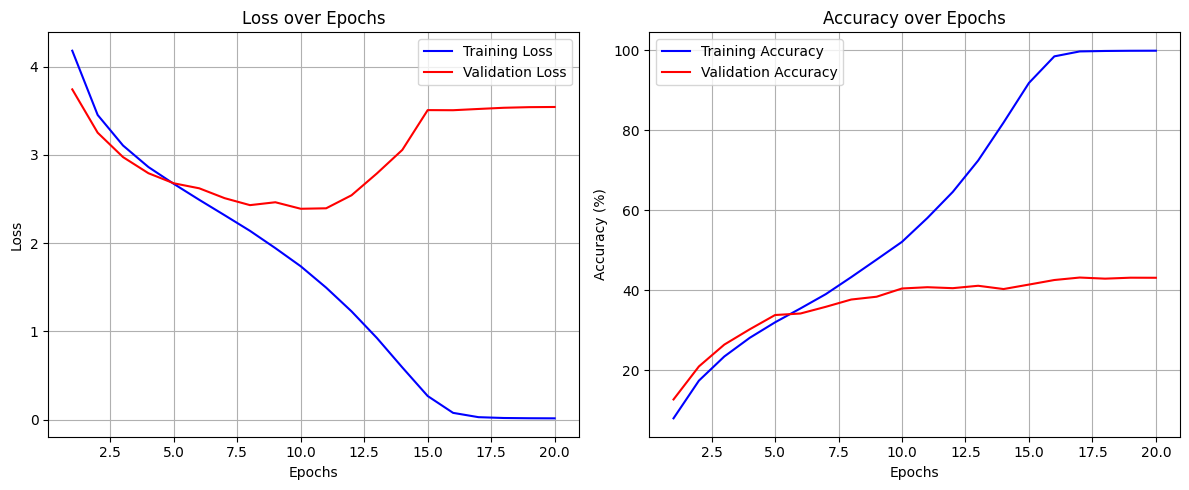

In [ ]:
# Run the baseline
if __name__ == "__main__":
    run_centralized_baseline()